In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))

import math
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
import networkx as nx

from embeddings.solver import Solver
from embeddings.main import (
    get_model_dir,
    commit_hash_latest_model,
    embedding_size
)
from embeddings.datasets import (
    erdos_renyi_dataset,
    watts_strogatz_dataset,
    barabasi_albert_dataset,
    all_combined_dataset,
    combine
)
from embeddings.feature_generators import (
    degree_ones_features,
    degree_sorted_features,
    degree_rand_features,
    degree_sorted_random_features,
)

from utils import load_pickle

from sklearn.manifold import TSNE

In [2]:
base_dir = "../"
data_dir = os.path.join(base_dir, "data/synthetic")
model_base_dir = os.path.join(base_dir, "embeddings/models")

In [3]:
# choose model and datasets etc.

model_version_hash = commit_hash_latest_model
description = ''
k = 2
feature_gen = degree_ones_features


test_data = all_combined_dataset(base_dir=data_dir,
                                 indices=range(80, 81), # take only one graph from each distribution
                                 compute_features=feature_gen)

train_data = all_combined_dataset(base_dir=data_dir, indices=range(80), compute_features=feature_gen)

In [4]:
model_dir = get_model_dir(model_base_dir, train_data, k=k, feature_gen=feature_gen, description=description,
                         model_hash=model_version_hash, must_exist=True)

solver = Solver(embedding_size=embedding_size, k=k, model_dir=model_dir, load=True)

embedding_model = solver.embedding_model

graph_embeddings = []
node_embeddings = []

data_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=4)

In [5]:
def is_boundary_node(n, G, node2partition):
    for u in G.neighbors(n):
        if node2partition[u] != node2partition[n]:
            return True
    return False

def get_boundary_nodes(G, partition):
    node2partition = {n: i for i, p in enumerate(partition) for n in p}
    
    return [is_boundary_node(n, G, node2partition) for n in G.nodes]

In [10]:
def get_graph(graph_dir_path, i):
    f_name = os.path.join(graph_dir_path, 'G_{}.pkl'.format(i))
    G = load_pickle(f_name)
    
    return G


def get_elem(i, data_loader):
    idx = 0
    for features, adj, n, m, param_info in data_loader:
        if idx == i:
            return features, adj, n, m, param_info
        idx += 1
    raise ValueError('does not contain element {}'.format(i))
    
def get_embeddings_and_info(i, data_loader, model):
    features, adj, n, m, param_info = get_elem(i, data_loader)
    features, adj = features[0], adj[0]
    
    embeddings = model(features, adj)
    embeddings = embeddings.detach().numpy()
    
    graph_dir_path = param_info[0][0]
    graph_dir_name = param_info[1][0]
    G = get_graph(graph_dir_path, i)
    
    try:
        f_kern = os.path.join(graph_dir_path, 'kernighan_lin_{}'.format(i))
        kern_lin = load_pickle(f_kern)
    except:
        kern_lin = None
    
    return embeddings, G, kern_lin, graph_dir_name
    
    
def plot_tsne_graph(i, data_loader, model):    
    embeddings, G, kern_lin, graph_dir = get_embeddings_and_info(i, data_loader, model)
    
    embedding_tsne = TSNE(learning_rate=200, perplexity=20, n_iter=5000).fit_transform(embeddings)
    
    # by degree
    degrees = list(map(lambda x: x[1], G.degree))
    
    sns.scatterplot(embedding_tsne[:,0], embedding_tsne[:,1], hue=degrees)
    plt.title(graph_dir + "\n colored by node degree")
    plt.show()
    
    # by is boundary node
    if kern_lin is not None:
        boundary_node = get_boundary_nodes(G, kern_lin)
    
        sns.scatterplot(embedding_tsne[:,0], embedding_tsne[:,1], hue=boundary_node)
        plt.title(graph_dir + "\n colored by is boundary node")
        plt.show()
  

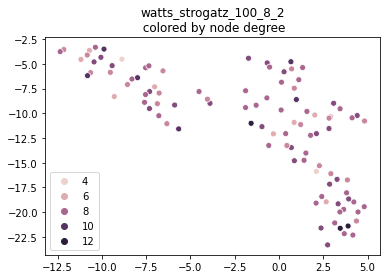

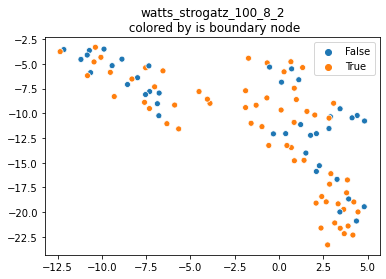

In [11]:
i = 19

plot_tsne_graph(i, data_loader, embedding_model)

# Analyze all Nodes from all Graphs

In [12]:
# analyze all nodes

degrees = []
embeddings = []
tsnes = []
graphs = []
node_ids = []
triangles = []


for i in tqdm(range(len(data_loader))):
    embeddings_graph, G, kern_lin, graph_dir = get_embeddings_and_info(i, data_loader, embedding_model)
    embeddings += list(embeddings_graph)
    
    tri_dict = nx.triangles(G)
    for n in G.nodes:
        graphs.append(G)
        node_ids.append(n)
        triangles.append(tri_dict[n])
    
    embedding_tsne = TSNE(learning_rate=200, perplexity=20, n_iter=1000).fit_transform(embeddings_graph)
    tsnes += list(embedding_tsne)

    
    degrees += list(map(lambda x: x[1], G.degree))

    
tsnes = np.array(tsnes)
degrees = np.array(degrees)
embeddings = np.array(embeddings)
triangles = np.array(triangles)

In [13]:
print(len(embeddings))

13380


## t-SNE

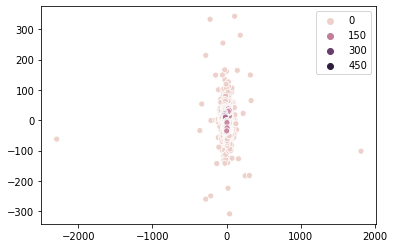

In [14]:
sns.scatterplot(tsnes[:,0], tsnes[:,1], hue=degrees)

### without outliers

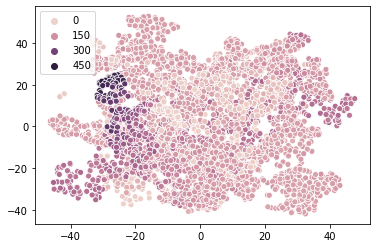

In [15]:
mask = [d > 50 for d in degrees]
sns.scatterplot(tsnes[mask,0], tsnes[mask,1], hue=degrees[mask])

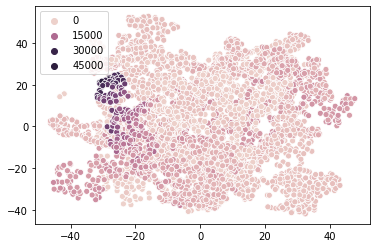

In [16]:
mask = [d > 50 for d in degrees]
sns.scatterplot(tsnes[mask,0], tsnes[mask,1], hue=triangles[mask])

# Correlations

In [17]:
import random
from networkx.algorithms.connectivity import minimum_st_edge_cut


In [18]:
unique_graphs = set(graphs)
print(len(unique_graphs))

49


In [19]:
def get_distance(G, n1, n2):
    if n1 == n2:
        return 0
    
    emb_1 = None
    emb_2 = None
    
    for i, G_list in enumerate(graphs):
        if G_list != G:
            continue
            
        if node_ids[i] == n1:
            emb_1 = embeddings[i]
        elif node_ids[i] == n2:
            emb_2 = embeddings[i]
        else:
            continue
        if emb_1 is not None and emb_2 is not None:
            return np.linalg.norm(emb_1 - emb_2)
    
    raise ValueError("these nodes don't exits in this graph")

In [20]:
node_pairs = []
st_cuts = []
shortest_paths = []
embedding_distances = []


for G in tqdm(unique_graphs):
    if len(G) > 100:
        continue
    node_list = list(G.nodes)
    for i in range(10):
        n1 = random.choice(node_list)
        n2 = random.choice(node_list)
        
        # inefficient but does not matter
        embedding_distances.append(get_distance(G, n1, n2))
        
        node_pairs.append((n1, n2, G))
        
        if n1 != n2:
            st_cuts.append(len(minimum_st_edge_cut(G, n1, n2))) # this does only work on unwieghted graphs !!
        else:
            st_cuts.append(0)
        shortest_paths.append(nx.shortest_path_length(G, source=n1, target=n2))

In [21]:
print("Correlation between distance in graph and in embedding space: {}"
      .format(np.corrcoef(np.array(shortest_paths), np.array(embedding_distances))[0,1]))
print("Correlation between s-t cut and distance in embedding space: {}"
      .format(np.corrcoef(np.array(st_cuts), np.array(embedding_distances))[0,1]))

Correlation between distance in graph and in embedding space: -0.04928350334592051
Correlation between s-t cut and distance in embedding space: 0.1461979776963141


# Edge prediction

In [22]:
def get_embedding(G, n):
    for i,G_list in enumerate(graphs):
        if G == G_list and node_ids[i] == n:
            return embeddings[i]
    raise ValueError('Could not find node in given graph')
        

In [23]:
node_pairs = []
embedding_pairs = []
edge_exists = []

max_per_graph = 50

for G in tqdm(unique_graphs):
    edges = list(G.edges)[:max_per_graph]
    non_edges = [(u,v) for u in G.nodes for v in G.nodes if v > u and (u,v) not in edges][:max_per_graph]
  
    node_list = list(G.nodes)
    
    new_pairs = edges + non_edges
    node_pairs += new_pairs
    edge_exists += [1 for _ in edges] + [0 for _ in non_edges]
    
    embedding_pairs += [np.concatenate([get_embedding(G, u), get_embedding(G, v)]) for u,v in new_pairs]
        

In [24]:
from sklearn.model_selection import train_test_split

X = np.array(embedding_pairs)
y = np.array(edge_exists)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=123)

In [25]:
len(X_train)

3568

In [26]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
clf = clf.fit(X_train, y_train)

In [27]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

parameters = {'learning_rate':[0.1, 1], 'max_depth':range(4,12,4), 'n_estimators':[100, 200]}

clf = GridSearchCV(xgb.XGBClassifier(), param_grid=parameters, verbose=2)
clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] learning_rate=0.1, max_depth=4, n_estimators=100 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . learning_rate=0.1, max_depth=4, n_estimators=100, total=   0.7s
[CV] learning_rate=0.1, max_depth=4, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] . learning_rate=0.1, max_depth=4, n_estimators=100, total=   0.7s
[CV] learning_rate=0.1, max_depth=4, n_estimators=100 ................
[CV] . learning_rate=0.1, max_depth=4, n_estimators=100, total=   0.7s
[CV] learning_rate=0.1, max_depth=4, n_estimators=100 ................
[CV] . learning_rate=0.1, max_depth=4, n_estimators=100, total=   0.7s
[CV] learning_rate=0.1, max_depth=4, n_estimators=100 ................
[CV] . learning_rate=0.1, max_depth=4, n_estimators=100, total=   0.7s
[CV] learning_rate=0.1, max_depth=4, n_estimators=200 ................
[CV] . learning_rate=0.1, max_depth=4, n_estimators=200, total=   1.5s
[CV] learning_rate=0.1, max_depth=4, n_estimators=200 ................
[CV] . learning_rate=0.1, max_depth=4, n_estimators=200, total=   1.3s
[CV] learning_rate=0.1, max_depth=4, n_estimators=200 ................
[CV] . learning_rate=0.1, max_depth=4, n_estimators=200, total=   1.3s
[CV] learning_rate=0.1, max_depth=4, n_estimators=200 ................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   59.4s finished


In [28]:
from sklearn.metrics import classification_report

y_true, y_pred = y_test, clf.predict(X_test)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       224
           1       0.86      0.77      0.81       222

    accuracy                           0.82       446
   macro avg       0.83      0.82      0.82       446
weighted avg       0.83      0.82      0.82       446



# Other prediction tasks

In [29]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def regression_report(y_true, y_pred):

    print("RMSE:", math.sqrt(mean_squared_error(y_true, y_pred)))
    print("R-squared", r2_score(y_true, y_pred))
    
    rel = np.mean(np.abs((y_pred / y_true)-1))
    print("Mean relative error: {:.2f}%".format(rel*100))

    plt.scatter(y_true, y_pred, s=1)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

In [30]:
# take at most 50 from each graph for balanced dataset
limit = 50

mask = []
G_prev = None
n_chosen = 0
for G in graphs:
    if G != G_prev:
        n_chosen = 1
        G_prev = G
        mask.append(True)
    elif n_chosen < limit:
        n_chosen += 1
        mask.append(True)
    else:
        mask.append(False)

## Predict number of triangles

RMSE: 2.737014550305817
R-squared 0.4560666159322454
Mean relative error: 42.48%


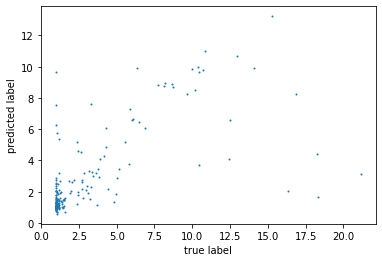

In [31]:
X = embeddings[mask]
y = triangles[mask] / np.array([len(G) for G in graphs])[mask] + 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=123)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate=0.5, max_depth=10, n_estimators=1000)
xg_reg = xg_reg.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="rmse", eval_set=[(X_val, y_val)], verbose=False)

y_true, y_pred = y_test, xg_reg.predict(X_test)

regression_report(y_true, y_pred)

## Predict node degree

RMSE: 0.08254566752386253
R-squared 0.6069759757445964
Mean relative error: 202.27%


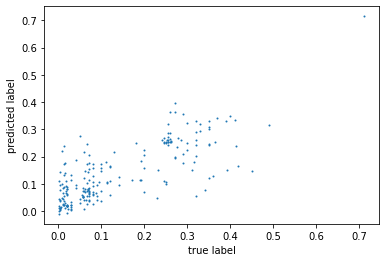

In [32]:
X = embeddings[mask]
y = degrees[mask] / np.array([len(G) for G in graphs])[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=123)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate=0.5, max_depth=10, n_estimators=1000)
xg_reg = xg_reg.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="rmse", eval_set=[(X_val, y_val)], verbose=False)

y_true, y_pred = y_test, xg_reg.predict(X_test)

regression_report(y_true, y_pred)